In [1]:
import os
from os import listdir

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from PIL import Image
import rasterio
from rasterio.plot import show
import requests
import shapely
from shapely import segmentize
from shapely.ops import substring
from shapely.geometry import LineString, Point
from shapely.geometry.polygon import Polygon


In [2]:
## Viewing cross-section example

# Inputs
lid = 'bltn7'
huc = '06010105'
catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
catfim_outputs_path = '/data/catfim/emily_test/hand_4_5_11_1_catfim_datavis_flow_based/'

# Viewing AUON6 

# # Inputs
# lid = 'AUON6'
# huc = '04140201'
# # catfim_inputs_path = '/data/outputs/hand_4_5_11_1_catfim'
# catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
# catfim_outputs_path = '/data/catfim/hand_4_5_11_1_stage_based/'

# Viewing PACI1

# Inputs
# lid = 'paci1'
# huc = '17060108'
# catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
# catfim_outputs_path = '/data/catfim/hand_4_5_11_1_stage_based/'

# ## Viewing Alaska BEFORE updates

# # Inputs
# lid = 'apta2'
# huc = '19020301'
# catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
# catfim_outputs_path = '/data/catfim/hand_4_5_11_1_flow_based'

## Viewing Alaska updates

# # Inputs
# lid = 'apta2'
# huc = '19020301'
# catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
# catfim_outputs_path = '/data/catfim/emily_test/AK_new_wrds_flow_based/'

### Reading in and processing CatFIM library and geospatial data

In [55]:
def read_catfim_outputs(catfim_inputs_path, huc):
    '''
    Read in HAND and CatFIM data, constructing filepaths as needed. 
    
    Inputs: 
    - catfim_inputs_path
    - huc
    
    Outputs:
    - catfim_library
    - catfim_points
    - flowline_gdf
    
    catfim_library, catfim_points, flowline_gdf = read_catfim_outputs(catfim_inputs_path, huc)
    
    '''
    
    # Read in HAND output flowlines
    flowline_path = os.path.join(catfim_inputs_path, huc,'nwm_subset_streams_levelPaths_dissolved.gpkg')
    flowline_gdf = gpd.read_file(flowline_path)

    # Read in CatFIM outputs
    catfim_outputs_mapping_path = os.path.join(catfim_outputs_path, 'mapping')

    for file in os.listdir(catfim_outputs_mapping_path):
        if file.endswith('catfim_library.gpkg'):
            catfim_library_path = os.path.join(catfim_outputs_path, 'mapping', file)
        elif file.endswith('catfim_sites.gpkg'):
            catfim_points_path = os.path.join(catfim_outputs_mapping_path, file)

    try:
        catfim_library = gpd.read_file(catfim_library_path)
        catfim_points = gpd.read_file(catfim_points_path)

    except IOError:
        print(f'Error opening CatFIM outputs from {catfim_outputs_path}:')
        print(IOError)
        sys.exit()

    print('HAND-FIM and CatFIM outputs have been read in.')
    
    return catfim_library, catfim_points, flowline_gdf


def subset_catfim_geom_by_site(lid, catfim_library, catfim_points, EPSG):
    '''
    Subset CatFIM library and points for a specific site.
    
    Inputs:
    - lid
    - catfim_library
    - catfim_points
    - EPSG
    
    Outputs: 
    - catfim_library_filt
    - points_filt_gdf
    - flowline_filt_gdf
    
    catfim_library_filt, points_filt_gdf, flowline_filt_gdf = subset_catfim_geom_by_site(lid, catfim_library, catfim_points, EPSG)
    
    '''
    
    # Filter points to LID
    points_filt_gdf = catfim_points[catfim_points['ahps_lid'] == lid] 

    if len(points_filt_gdf) > 1:
        print(f'ERROR: Multiple points found for lid {lid}.')
        sys.exit()

    # Put the point into the projection of the flowlines
    # points_filt_gdf = points_filt_gdf.to_crs(flowline_gdf.crs) 
    points_filt_gdf = points_filt_gdf.to_crs(EPSG) 


    # Find the flowline nearest to the point 
    flowline_filt_gdf = gpd.sjoin_nearest(flowline_gdf, points_filt_gdf, max_distance=100)

    catfim_library_filt = catfim_library[catfim_library['ahps_lid']==lid]
    catfim_library_filt = catfim_library_filt.to_crs(points_filt_gdf.crs) # TODO: check that this is doing what we want it to

    # Put the geometries into a unified projection
    points_filt_gdf = points_filt_gdf.to_crs(EPSG)
    flowline_filt_gdf = flowline_filt_gdf.to_crs(EPSG)
    catfim_library_filt = catfim_library_filt.to_crs(EPSG)
    
    print(f'Filtered points and flowlines for {lid}.')
    
    return catfim_library_filt, points_filt_gdf, flowline_filt_gdf

def subset_apply_symbology_catfim_library(catfim_library, lid, include_record):
    '''
    Subset CatFIM library by site and apply the appropriate symbology. 
    
    Inputs: 
    - catfim_library
    - lid
    - include_record (True or False)
    
    Outputs: 
    - catfim_library_filt
    
    catfim_library_filt = subset_apply_symbology_catfim_library(catfim_library, lid, include_record=True)
    
    '''

    catfim_library_filt = catfim_library[catfim_library['ahps_lid']==lid]
    catfim_library_filt = catfim_library_filt.to_crs(points_filt_gdf.crs) # TODO: check that this is doing what we want it to

    # Create dictionary of color and orders
    if include_record == True: 
        categories = ['action', 'minor', 'moderate', 'major', 'record']
        colors = ['yellow', 'orange', 'red', 'purple', 'cyan']
        orders = [5, 4, 3, 2, 1]
    elif include_record == False:
        categories = ['action', 'minor', 'moderate', 'major']
        colors = ['yellow', 'orange', 'red', 'purple']
        orders = [5, 4, 3, 2]
    else:
        sys.exit('Invalid input for include_record parameter.')

    colordict = dict(zip(categories, colors))  
    orderdict = dict(zip(categories, orders))  

    catfim_library_filt['color'] = catfim_library_filt['magnitude'].apply(lambda x: colordict[x])
    catfim_library_filt['plot_order'] = catfim_library_filt['magnitude'].apply(lambda x: orderdict[x])

    catfim_library_filt = catfim_library_filt.sort_values(by='plot_order') 

    print('Subsetted, filtered, and applied visualization preferences to CatFIM library.')
    
    return catfim_library_filt, colordict


In [56]:
EPSG = 5070

# Read in the CatFIM outputs
catfim_library, catfim_points, flowline_gdf = read_catfim_outputs(catfim_inputs_path, huc)

# Subset the CatFIM geometries by site and enforce projection
catfim_library_filt, points_filt_gdf, flowline_filt_gdf = subset_catfim_geom_by_site(lid, catfim_library, catfim_points, EPSG)

# Filter CatFIM library and create the symbology columns
catfim_library_filt, colordict = subset_apply_symbology_catfim_library(catfim_library, lid, include_record=True)

HAND-FIM and CatFIM outputs have been read in.
Filtered points and flowlines for bltn7.
Subsetted, filtered, and applied visualization preferences to CatFIM library.


### Plotting CatFIM library

In [91]:
def map_catfim_at_site(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, colordict, plot_title, EPSG, basemap, site_view, legend):
    '''
    Plot data layers on top of a ESRI basemap in a square bounding box. 
    The bounding box determined by a site centroid OR the extent of the 
    CatFIM library for the site.
    
    Inputs: 
    - catfim_library_filt
    - flowline_filt_gdf
    - points_filt_gdf (CatFIM site geodataframe, used as centroid if site_view = True)
    - colordict
    - plot_title (string, title of plot)
    - EPSG (5070 suggested)
    - basemap (True or False, determines whether an ESRI basemap is imported)
    - site_view (True or False, if true then it will zoom in on site, if False it will show the full CatFIM library for the site)
    
    map_catfim_at_site(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, colordict, plot_title='', EPSG=5070, basemap=True, site_view=True, legend = True) 
                       
    '''
    # Create the bounding box
    if site_view == True:
        
        map_centroid = points_filt_gdf
    
        # Reproject centroid
        map_centroid = map_centroid.to_crs(EPSG)

        # Input information to calculate bounding box
        map_length = 1000 # 100 ft/m buffer around point, hard-coded for now

        # Calculate bounding box
        ycoord = int(map_centroid.get_coordinates()['y'].iloc[0])
        xcoord = int(map_centroid.get_coordinates()['x'].iloc[0])

        map_length_half = map_length/2

        xleft = xcoord-map_length_half
        xright = xcoord+map_length_half
        ybottom = ycoord-map_length_half
        ytop = ycoord+map_length_half

        x = (xleft, xright)
        y = (ybottom, ytop)
        
    elif site_view == False:
        
        # Get bounding rectangle of filtered CatFIM library
        xmin_bounds, ymin_bounds, xmax_bounds, ymax_bounds = catfim_library_filt.total_bounds

        # Get max length of CatFIM bounding rectangle
        xlen = xmax_bounds-xmin_bounds
        ylen = ymax_bounds-ymin_bounds
        max_len = max(xlen, ylen)

        # Create centroid coords
        xcoord = xmin_bounds + xlen/2
        ycoord = ymin_bounds + ylen/2

        # Make a new bounding square, using CatFIM centroid and the max rectangle length
        map_length_half = max_len/2

        xleft = xcoord-map_length_half
        xright = xcoord+map_length_half
        ybottom = ycoord-map_length_half
        ytop = ycoord+map_length_half

        # Organize new bounding box coordinates
        x = (xleft, xright)
        y = (ybottom, ytop)

    # Assmeble baseplot
    f, ax = plt.subplots(figsize=(10, 10))

    if basemap == True: 
        # Pull aerial imagery basemap from ESRI API
        esri_url = f"https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?bbox={x[0]}%2C{y[0]}%2C{x[1]}%2C{y[1]}&bboxSR={EPSG}&layers=0&size=&imageSR=5070&transparent=true&dpi=200&f=image"
        esri_aerial = Image.open(requests.get(esri_url, stream=True).raw).convert('RGBA')
        im = ax.imshow(esri_aerial, extent=(x[0],x[1],y[0],y[1]))

    if legend == True:
        # Create legend from the color dictionary
        stages = list(colordict.keys())
        patches = []
        for stage in stages: 
            patch = mpatches.Patch(color = colordict[stage], label = stage)
            patches.append(patch)

        ax.legend(handles=patches)
        
    # Add additional geodataframe layers
    catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.5)
    flowline_filt_gdf.plot(ax=ax, color='black', alpha=0.5) 
    points_filt_gdf.plot(ax=ax, color='black', alpha=0.5)

    # Set bounds and labels
    ax.set_xbound([x[0],x[1]])
    ax.set_ybound([y[0],y[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plot_title)

    plt.show()

def map_catfim_full_extent(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, colordict, plot_title, legend):
    '''
    Plot data layers on top of a ESRI basemap... bounding box determined by a centroid.
    
    Inputs: 
    - catfim_library_filt
    - flowline_filt_gdf
    - points_filt_gdf
    - colordict
    - plot_title (string, title of plot)
    - legend (True or False)
    
    map_catfim_full_extent(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, colordict, plot_title='', legend=True)
    
    '''

    # Set up CatFIM plot
    f, ax = plt.subplots()
    catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.75)

    # Additional geodataframe layers
    flowline_filt_gdf.plot(ax=ax, color='blue', alpha=0.8)  
    points_filt_gdf.plot(ax=ax, color='black', alpha=1)  
    
    if legend == True:
        # Create legend from the color dictionary
        stages = list(colordict.keys())
        patches = []
        for stage in stages: 
            patch = mpatches.Patch(color = colordict[stage], label = stage)
            patches.append(patch)

        ax.legend(handles=patches)

    # Set the plot extent to the bounds of the CatFIM section
    minx, miny, maxx, maxy = catfim_library_filt.total_bounds
    modifier = 10 # how much to widen the extent by
    ax.set_xlim(minx-modifier, maxx+modifier)
    ax.set_ylim(miny-modifier, maxy+modifier)

    ax.set_title(plot_title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()    



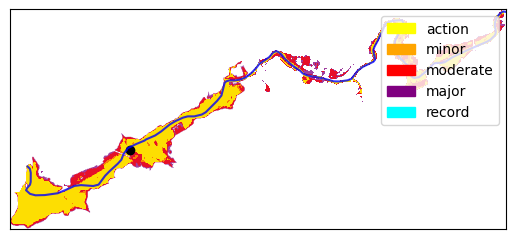

In [90]:
# map_catfim_at_site(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, plot_title='', EPSG=5070, basemap=True, site_view=True)

map_catfim_full_extent(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, colordict, plot_title='', legend=True)

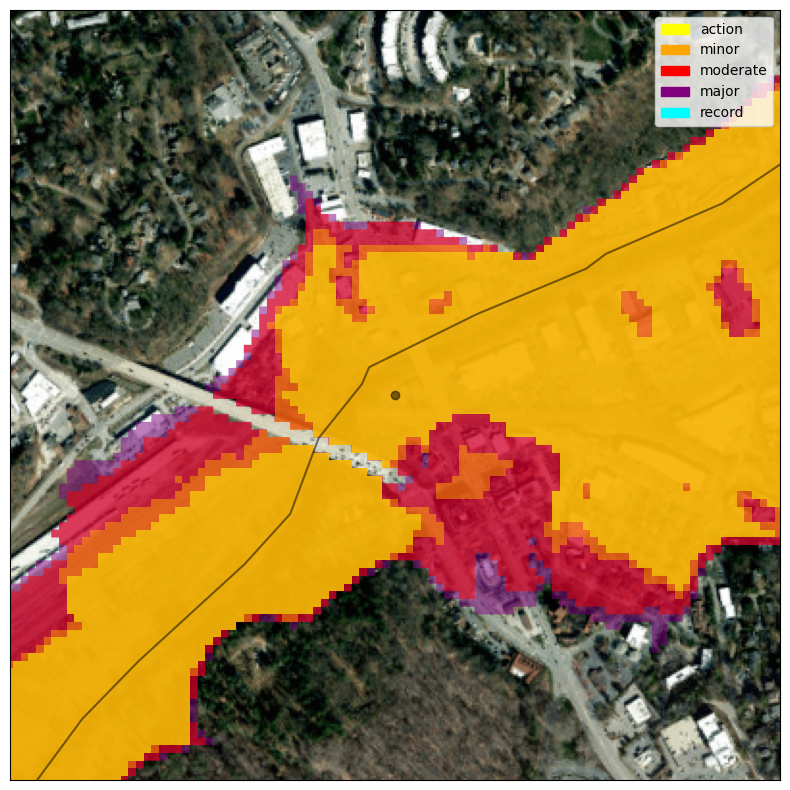

In [95]:
map_catfim_at_site(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, colordict, plot_title='', EPSG=5070, basemap=True, site_view=True, legend = True) 

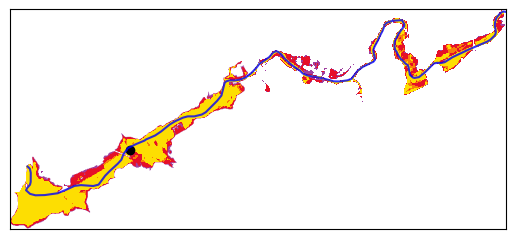

In [94]:
map_catfim_full_extent(catfim_library_filt, flowline_filt_gdf, points_filt_gdf, colordict, plot_title='', legend=False)

### Generate and Plot CatFIM Elevation Cross-section

In [84]:
def create_perpendicular_cross_section(flowline_filt_gdf, points_filt_gdf, xsection_length, EPSG):
    '''
    Creates a perpendicular cross-section of a single flowline with a specified length. 
    
    Inputs: 
    - flowline_filt_gdf
    - points_filt_gdf 
    - xsection_length (in the projection units, 1000 is suggested)
    - EPSG (number, 5070 is suggested)
    
    Outputs: 
    - xsection_gdf
    
    '''

    # Extract the line and the point
    line = flowline_filt_gdf.geometry.iloc[0]
    point = points_filt_gdf.geometry.iloc[0]


    # Find the segment of the line near the point of interest
    segment_length = 20 # meters or feet 
    segment_start_distance = max(0, line.project(point) - segment_length / 2)
    segment_end_distance = min(line.length, segment_start_distance + segment_length)

    # Create a shorter segment from the original line
    short_segment = LineString([
        line.interpolate(segment_start_distance),
        line.interpolate(segment_end_distance)
    ])

    # Calculate the slope of the shorter line segment
    line_vector = np.array(short_segment.xy[1]) - np.array(short_segment.xy[0])
    line_vector /= np.linalg.norm(line_vector)  # Normalize
    perpendicular_vector = np.array([-line_vector[1], line_vector[0]])  # Perpendicular vector

    # Create the cross section line (10 meters long)
    half_length = xsection_length / 2
    start_point = (point.x + half_length * perpendicular_vector[0], point.y + half_length * perpendicular_vector[1])
    end_point = (point.x - half_length * perpendicular_vector[0], point.y - half_length * perpendicular_vector[1])
    new_line = LineString([start_point, end_point])

    # Create a GeoDataFrame for the new line
    xsection_gdf = gpd.GeoDataFrame({'geometry': [new_line]}, crs=flowline_filt_gdf.crs)
    
    # Project geodataframe
    xsection_gdf = xsection_gdf.to_crs(EPSG)

    print(f'Created cross-section of length {xsection_length}.')
    
    return xsection_gdf

def map_cross_section_geometry(xsection_gdf, points_filt_gdf, flowline_filt_gdf, modifier, plot_title):

    # Plot xsection_gdf first to set the extent
    ax = xsection_gdf.plot(figsize=(6, 6), color='lightgray')

    # Add data
    points_filt_gdf.plot(ax=ax, color='blue', alpha=0.5, zorder=5)  # Adjust color and alpha as needed
    flowline_filt_gdf.plot(ax=ax, color='green', alpha=0.5)  # Adjust color and alpha as needed

    # Set the plot extent to the bounds of the line segment
    minx, miny, maxx, maxy = xsection_gdf.total_bounds
    ax.set_xlim(minx-modifier, maxx+modifier)
    ax.set_ylim(miny-modifier, maxy+modifier)
    ax.set_title(plot_title)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

def create_cross_section_points(xsection_gdf, dist_between_points): 
    '''
    Creates points at a specified distance along a cross-section line.
    
    Inputs:
    - xsection_gdf: Cross-section line
    - dist_between_points: Distance interval with which to create points. 
    
    Outputs: 
    - xsection_points_gdf: Points along the cross-section line.
    - xsection_midpoint: Distance of halfway point.
    
    '''

    # Create points along cross-section line
    xsection_line = xsection_gdf.geometry.iloc[0]
    
    # Initialize cross-section points geometry
    xsection_points = shapely.geometry.MultiPoint()

    # Initialize the dist_along_line list
    half_dist_between_points = [dist_between_points/2] 
    dist_along_line = [] 

    # Iterate through cross-section line length and create points along the line
    for i in np.arange(0, xsection_line.length, dist_between_points):

        # Get midpoint geometry
        s = substring(xsection_line, i, i+dist_between_points)
        
        # Add value to cross-section points geometry
        xsection_points = xsection_points.union(s.boundary)

        # dist_along_line.append(i+dist_between_points) # TODO: should this be dist_between_points/2? to get the middle?
        dist_along_line.append(i+half_dist_between_points) # changed so it's the halfway value

    # Turn the multipoint object into a geodataframe
    xsection_points_gdf = gpd.GeoDataFrame({'geometry': [xsection_points], 'elev': -9999},
                                           crs=xsection_gdf.crs).explode(index_parts=True)

    # Add line distance column
    xsection_points_gdf['dist_along_line'] = dist_along_line

    # Calculate the cross section halfway point
    xsection_midpoint = dist_along_line[int(len(dist_along_line)/2)]

    print(f'Generated {len(xsection_points_gdf)} cross-section points.')

    return xsection_points_gdf, xsection_midpoint


def generate_dem_path(huc, root_dem_path):
    '''
    Generates a DEM path using the HUC and the root DEM path.
    
    Inputs: 
    - huc (string)
    - root DEM path (string, probably /data/inputs/3dep_dems/)
    
    Outputs: 
    - HUC DEM path
    
    '''
    if huc[0:2] == '19':
        dem_name = f'HUC8_{huc}_dem.tif'
        dem_path = os.path.join(root_dem_path, '10m_South_Alaska', '23_11_07', dem_name)
    else:
        huc6 = huc[0:6]
        dem_name = f'HUC6_{huc6}_dem.tif'
        dem_path = os.path.join(root_dem_path, '10m_5070', dem_name)
    
    print(f'DEM path generated: {dem_path}')
    
    return dem_path


def get_elevation_for_cross_section_points(dem_path, xsection_points_gdf, EPSG):
    '''
    Gets the elevation for at each point from the DEM.
    
    Inputs:
    - dem_path (string)
    - xsection_points_gdf
    - EPSG (numerical, i.e. 5070)
    
    Outputs:
    - xsection_points_elev_gdf
    
    '''

    # Read the raster file
    with rasterio.open(dem_path) as src:

        # Get raster projection
        rast_proj = src.crs

        # Temporarily project cross-section points to match raster (it's easier this way)
        xsection_points_temp_proj_gdf = xsection_points_gdf.to_crs(rast_proj)

        # Extract raster values at point locations
        values = []
        for point in xsection_points_temp_proj_gdf.geometry:
            x, y = point.x, point.y
            row, col = src.index(x, y)
            value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
            values.append(value)

        # Add values to the point dataframe
        xsection_points_temp_proj_gdf['elev'] = values

    # Overwrite the old crosssection points gdf with the new elevation one
    xsection_points_elev_gdf = xsection_points_temp_proj_gdf.to_crs(EPSG)
    
    print('Got elevation for each cross-section point.') 
    return xsection_points_elev_gdf

def apply_catfim_library_to_points(xsection_points_gdf, catfim_library_filt):
    '''
    Overlays the filtered CatFIM library onto the cross-section points to provide the lowest potential flood stage for each point.
    
    Inputs: 
    - xsection_points_gdf
    - catfim_library_filt
    
    Outputs:
    - xsection_catfim_filt_gdf
    '''

    xsection_points_overlay_gdf = gpd.overlay(xsection_points_gdf, catfim_library_filt, how='intersection')

    distances_list = []
    for i, x in enumerate(xsection_points_overlay_gdf['dist_along_line']):   
        distances_list.append(xsection_points_overlay_gdf['dist_along_line'][i][0])

    # Iterate through each distance marker and filter so there's only one row per point (with smallest flood level kept)
    xsection_catfim_filt = []
    
    for dist in distances_list:
        # Filter the rows given distance
        filtered_df = xsection_points_overlay_gdf[xsection_points_overlay_gdf['dist_along_line'] == dist]

        # Get the row with the highest plot order (color plotted on top)
        min_row = filtered_df.loc[filtered_df['plot_order'].idxmax()]

        # Append the result for this distance marker
        xsection_catfim_filt.append(min_row)

    # Convert the results list into a DataFrame to view all results
    xsection_catfim_filt_gdf = gpd.GeoDataFrame(xsection_catfim_filt)

    print('Intersected and overlaid cross section points with CatFIM library.')
    return xsection_catfim_filt_gdf

def plot_catfim_cross_section(xsection_points_gdf, xsection_catfim_filt_gdf, xsection_midpoint, 
                              colordict, elev_upper_buffer_ft, num_points_buffer, save_plot, plot_title, file_label):
    '''
    Plots the CatFIM cross section points with the inundation category.

    Inputs: 
    - xsection_points_gdf
    - xsection_catfim_filt_gdf
    - xsection_midpoint
    - colordict
    - elev_upper_buffer_ft (Number of ft above highest CatFIM library point to show, 10 suggested)
    - num_points_buffer (Number of points to show on either side of CatFIM library, 5 suggested)
    - save_plot (Whether to save the plot (True/False)
    - plot_label (Additional label for plot file, if needed)
    
    '''

    # Set up map
    f, ax = plt.subplots(figsize=(10, 4))

    # Add elevation line
    plt.plot(xsection_points_gdf.dist_along_line, xsection_points_gdf.elev, color = 'gray', alpha=0.8, zorder=2) 

    # Add CatFIM points
    plt.scatter(x=xsection_catfim_filt_gdf.dist_along_line, y=xsection_catfim_filt_gdf.elev, color=xsection_catfim_filt_gdf.color, alpha=0.9, edgecolor='black', lw=0.7, zorder=3)

    # Add a dotted line at the approximate LID location
    plt.axvline(x=xsection_midpoint, color='gray', linestyle='--', alpha=0.4)

    # Calculate x axis bounds with points buffer
    x_buffer = dist_between_points * num_points_buffer
    x_min = xsection_catfim_filt_gdf['dist_along_line'].min() - x_buffer
    x_max = xsection_catfim_filt_gdf['dist_along_line'].max() + x_buffer

    # Calculate y axis bounds with an elevation buffer
    y_min = xsection_catfim_filt_gdf['elev'].min() - 1
    y_max = xsection_catfim_filt_gdf['elev'].max() + elev_upper_buffer_ft

    # Create legend from the color dictionary
    stages = list(colordict.keys())
    patches = []
    for stage in stages: 
        patch = mpatches.Patch(color = colordict[stage], label = stage)
        patches.append(patch)
        
    ax.legend(handles=patches)

    # Set labels and axis bounds
    ax.set_xlabel('')
    ax.set_ylabel('Elevation, ft')
    ax.set_xbound([x_min,x_max])
    ax.set_ybound([y_min,y_max])
    ax.set_title(plot_title)

    # Save and display plot
    if save_plot == True:
        # Create plot filename
        plot_name = 'catfim_crosssection_' + lid + file_label + '.png'
        plt.savefig(plot_name)
        print(f'Saved plot as {plot_name}')

    else: 
        plt.show()
        
def map_catfim_cross_section_points(catfim_library_filt, flowline_filt_gdf, xsection_catfim_filt_gdf, 
                                    colordict, modifier, plot_title, basemap, legend):
    '''
    Plot data layers on top of a ESRI basemap... bounding box determined by the CatFIM cross section extent.
    
    Inputs:
    - catfim_library_filt
    - flowline_filt_gdf
    - xsection_catfim_filt_gdf
    - colordict
    - modifier 
    - plot_title 
    - basemap (True or False, depending on if you want the ESRI basemap)
    - legend (True or False, depending on if you want a legend)
    
    
    '''
    
    # Get bounding rectangle of filtered CatFIM library
    xmin_bounds, ymin_bounds, xmax_bounds, ymax_bounds = xsection_catfim_filt_gdf.total_bounds

    # Organize new bounding box coordinates
    x = (xmin_bounds-modifier, xmax_bounds+modifier)
    y = (ymin_bounds-modifier, ymax_bounds+modifier)


    # Assmeble baseplot
    f, ax = plt.subplots(figsize=(10, 10))
    
    if basemap == True: 
        # Pull aerial imagery basemap from ESRI API
        esri_url = f"https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?bbox={x[0]}%2C{y[0]}%2C{x[1]}%2C{y[1]}&bboxSR={EPSG}&layers=0&size=&imageSR=5070&transparent=true&dpi=200&f=image"
        esri_aerial = Image.open(requests.get(esri_url, stream=True).raw).convert('RGBA')

        im = ax.imshow(esri_aerial, extent=(x[0],x[1],y[0],y[1]))

    if legend == True:
        # Create legend from the color dictionary
        stages = list(colordict.keys())
        patches = []
        for stage in stages: 
            patch = mpatches.Patch(color = colordict[stage], label = stage)
            patches.append(patch)

        ax.legend(handles=patches)
        
    # Plot filtered CatFIM library
    catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.6)

    # Add additional geodataframe layers
    flowline_filt_gdf.plot(ax=ax, color='black', alpha=1) 
    xsection_catfim_filt_gdf.plot(ax=ax, color=xsection_catfim_filt_gdf['color'], edgecolor='black', lw=0.7, zorder=5)

    # Set bounds and labels
    ax.set_xbound([x[0],x[1]])
    ax.set_ybound([y[0],y[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plot_title)

    plt.show()

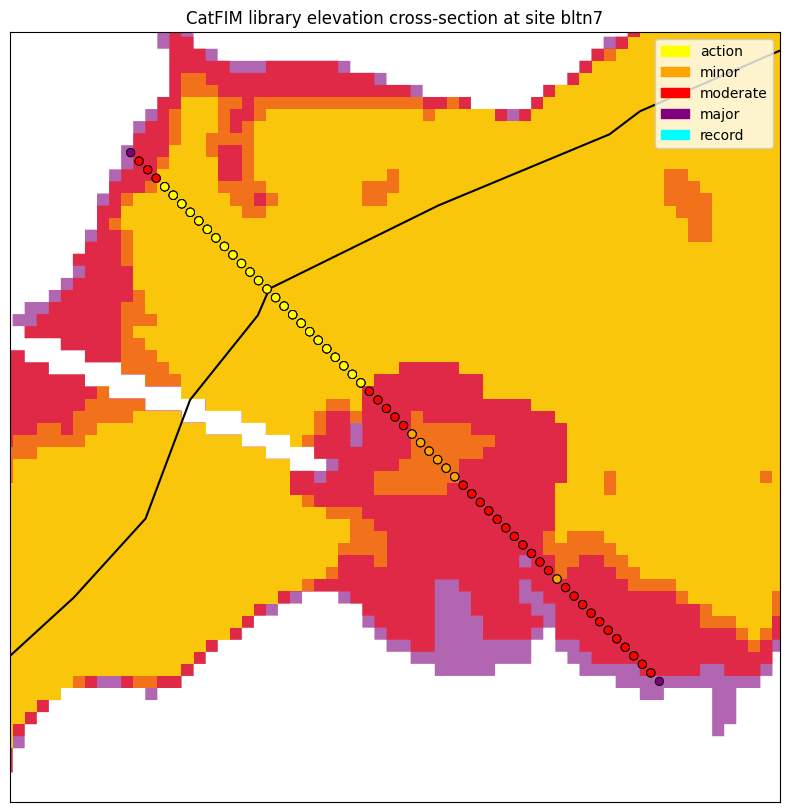

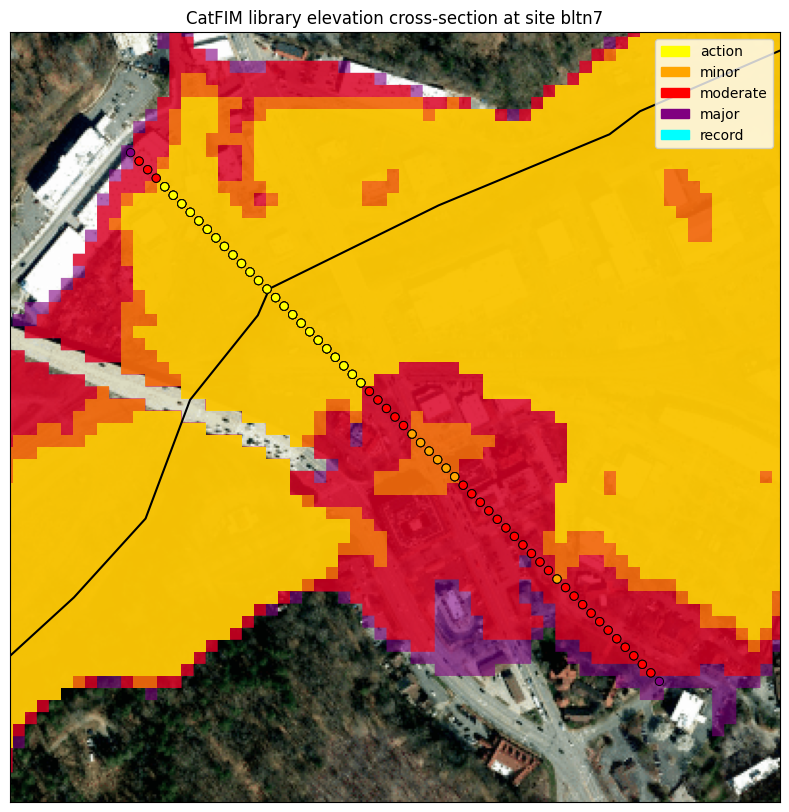

In [86]:
# Map the CatFIM stage cross-section
map_catfim_cross_section_points(catfim_library_filt, flowline_filt_gdf, xsection_catfim_filt_gdf, colordict, 
                                modifier=100, plot_title=f'CatFIM library elevation cross-section at site {lid}', 
                                basemap=False, legend=True)

# Map the CatFIM stage cross-section
map_catfim_cross_section_points(catfim_library_filt, flowline_filt_gdf, xsection_catfim_filt_gdf, colordict, 
                                modifier=100, plot_title=f'CatFIM library elevation cross-section at site {lid}', 
                                basemap=True, legend=True)

Created cross-section of length 1000.


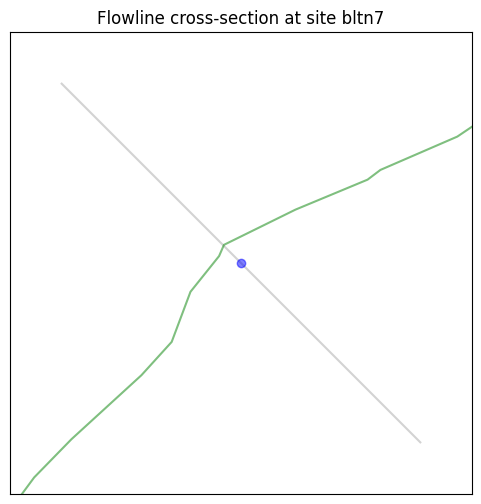

DEM path generated: /data/inputs/3dep_dems/10m_5070/HUC6_060101_dem.tif
Generated 101 cross-section points.
Got elevation for each cross-section point.
Intersected and overlaid cross section points with CatFIM library.


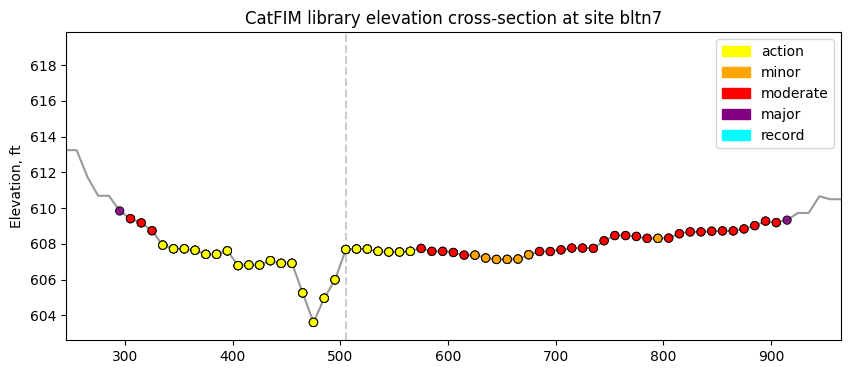

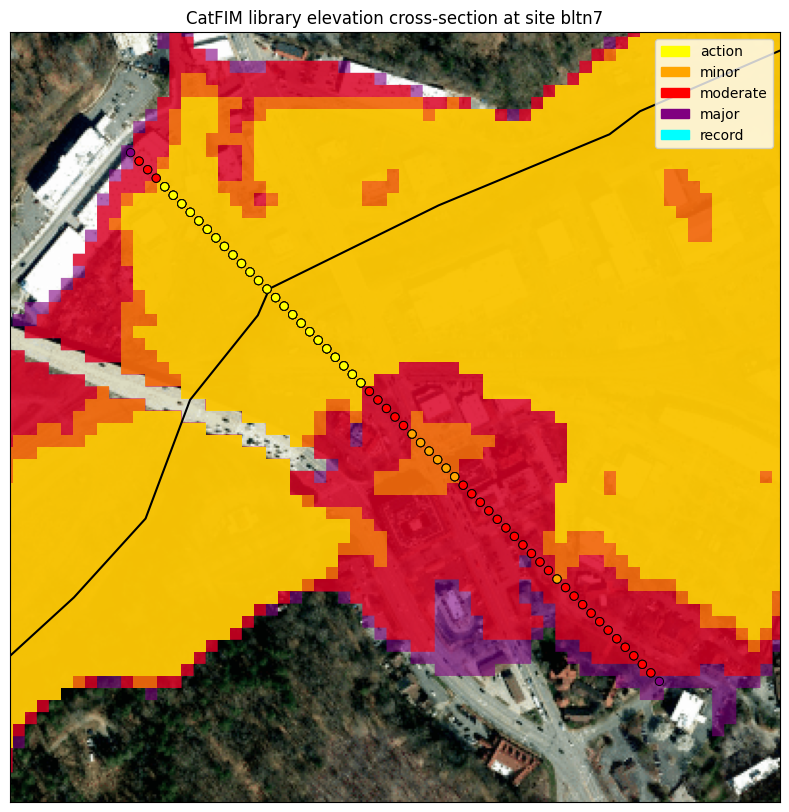

In [87]:
## Function Inputs ------------------------------------

xsection_length = 1000 # cross-section length, meters or feet, 1000 suggested
EPSG = 5070
dist_between_points = 10 # distance between points on cross-section line, 10 suggested


## Run Functions ------------------------------------

# Create cross-section
xsection_gdf = create_perpendicular_cross_section(flowline_filt_gdf, points_filt_gdf, xsection_length, EPSG)

# Map the cross-section
map_cross_section_geometry(xsection_gdf, points_filt_gdf, flowline_filt_gdf, modifier=100, plot_title=f'Flowline cross-section at site {lid}')

# Get DEM path
dem_path = generate_dem_path(huc, root_dem_path='/data/inputs/3dep_dems/')

# Create points along cross-section line
xsection_points_gdf, xsection_midpoint = create_cross_section_points(xsection_gdf, dist_between_points)

# Apply elevation to points
xsection_points_gdf = get_elevation_for_cross_section_points(dem_path, xsection_points_gdf, EPSG)

# Apply CatFIM stages to points
xsection_catfim_filt_gdf = apply_catfim_library_to_points(xsection_points_gdf, catfim_library_filt)

# Plot the CatFIM stage cross-section
plot_catfim_cross_section(xsection_points_gdf, xsection_catfim_filt_gdf, xsection_midpoint, colordict, elev_upper_buffer_ft=10, 
                          num_points_buffer=5, save_plot=False, plot_title = f'CatFIM library elevation cross-section at site {lid}', 
                          file_label='')

# Map the CatFIM stage cross-section
map_catfim_cross_section_points(catfim_library_filt, flowline_filt_gdf, xsection_catfim_filt_gdf, colordict, 
                                modifier=100, plot_title=f'CatFIM library elevation cross-section at site {lid}', 
                                basemap=True, legend=True)